Notebook 1. Processes data from subreddit "Malicious Compliance", then cleans the data using a custom stopword list 
created using the top words from Malicious Compliance and ProRevenge, the subreddit processed in [Notebook 2](./Tiffany_Baker_Project_3_Reddit_Notebook_2) .

In [263]:
#Retrieve data online and load
import requests as req 
import json
import re
import time
from datetime import datetime, timezone

#NLP libraries
from nltk.stem import WordNetLemmatizer as lemma
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords


#Variables to use for NLP
stop = stopwords.words('english')
punc = "?!,.;:)("

#Pandas
import pandas as pd

#Plot and model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier

In [2]:
#function to request data using pushshift
#takes
def so_fresh(n,sub,post_type):
    '''Takes in a number n, name of the subreddit(all lowercase), and post_type(either submissions, comments, or subreddit).
    Creates a request url to obtain data through the pushshift api from reddit.
    Returns a list of n dataframes comprised of 100 reddit post/comments.
    
    example: sub = sub_pull(100,"prorevenge","submission") 
    will run 100 iterations of the function to obtain posts from the prorevenge subreddit'''
    
    df_1 = []
    start = 1600822671
    for i in range(n):
        red_url = f"https://api.pushshift.io/reddit/search/{post_type}/?subreddit={sub}&before={start}&size=100"
        reqs = req.get(red_url, timeout = 30)
        stream = reqs.json()
        body = stream["data"]
        df = pd.DataFrame(body)[['selftext','subreddit','created_utc']]
        start=df['created_utc'].min()
        df_1.append(df)
        time.sleep(30)
        print(f"Pull {i} complete") #Chuck suggested to Tanner- incorporated here
  
    return df_1
        
        

In [4]:
#call the function
sub = so_fresh(100, "maliciouscompliance", "submission")

Pull 0 complete
Pull 1 complete
Pull 2 complete
Pull 3 complete
Pull 4 complete
Pull 5 complete
Pull 6 complete
Pull 7 complete
Pull 8 complete
Pull 9 complete
Pull 10 complete
Pull 11 complete
Pull 12 complete
Pull 13 complete
Pull 14 complete
Pull 15 complete
Pull 16 complete
Pull 17 complete
Pull 18 complete
Pull 19 complete
Pull 20 complete
Pull 21 complete
Pull 22 complete
Pull 23 complete
Pull 24 complete
Pull 25 complete
Pull 26 complete
Pull 27 complete
Pull 28 complete
Pull 29 complete
Pull 30 complete
Pull 31 complete
Pull 32 complete
Pull 33 complete
Pull 34 complete
Pull 35 complete
Pull 36 complete
Pull 37 complete
Pull 38 complete
Pull 39 complete
Pull 40 complete
Pull 41 complete
Pull 42 complete
Pull 43 complete
Pull 44 complete
Pull 45 complete
Pull 46 complete
Pull 47 complete
Pull 48 complete
Pull 49 complete
Pull 50 complete
Pull 51 complete
Pull 52 complete
Pull 53 complete
Pull 54 complete
Pull 55 complete
Pull 56 complete
Pull 57 complete
Pull 58 complete
Pull 59

In [5]:
def so_clean(df = sub):
    '''Takes in a dataframe, drops duplicates and nulls, then reports the change in shape
    default value is the sub created when so_fresh is called
    
    example: so_clean(df)
    returns df after dedupe and removing nulls'''
    

    df_sub= pd.concat(df)
    print (f"Starting dimensions: {df_sub.shape}")
    #drop duplicate rows based on values in "selftext"
    #this removes all the posts that have been deleted
    #or removed
    df_sub.drop_duplicates(["selftext"], keep = False, inplace = True)
    #drop nulls
    df_sub.dropna(how = "any", inplace = True)
    print (f"Ending dimensions: {df_sub.shape}")
    
    return df_sub


In [200]:
df_malicious=so_clean(sub)

In [134]:
def stantokenia(df):
    '''Function accepts dataframe. Tokenizes contents of the "selftext" column. Returns dataframe'''
    #create a column in the data frame of tokens comprised of the lowercase components of selftext
    #reddit text is similar to tweet text as opposed to standard speech
    #used TweetTokenizer to split my strings-http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual
    tokenizer = TweetTokenizer()
    df["tokens"] = df["selftext"].apply(tokenizer.tokenize)
    return df

In [165]:
df_malicious = stantokenia(df_malicious)

In [166]:
def rosa_parks(text):
    '''Lemmatizer. Accepts text, returns list'''
    
    lemmatizer = lemma()
    return [lemmatizer.lemmatize(w) for w in text] #from stack overflow, create function to apply to data frame

In [167]:
def roses(df):
    '''Function accepts dataframe. Applies lemmatizer to create "lemmas" and filters through stopwords to create
    "unique". Returns dataframe'''
    
    df["lemmas"]= df["tokens"].apply(rosa_parks)
    df["unique"] = df["lemmas"].apply(lambda x: [word for word in x if word not in (stop)])
    return df


In [168]:
df_malicious = roses(df_malicious)

Found this code on stackoverflow. Creates a list of the items in a dataframe series by iterating through the series. Then, counts the occurence of each token in the list using .value_counts() on a dataframe created from the
list of words and counts of occurences. 

The custom stopwords list is the intersection of tokens appearing in both top 500 lists.

In [71]:
full_list = []  # list containing all words of all texts
for elmnt in df_malicious['unique']:  # loop over lists in df
    full_list += elmnt  # append elements of lists to full list

val_counts = pd.Series(full_list).value_counts()  # make temporary Series to count

mal_top_500_count = val_counts.head(500).astype(int).tolist()
mal_top_500_index = val_counts.head(500).index.tolist()

mal_top_500 = list(zip(mal_top_500_index, mal_top_500_count))



retrieve stored lists of top tokens from other process

In [72]:
%store -r pro_top_500
%store -r pro_top_500_index

Combine top 500 tokens from each subreddit, look for tokens in both lists. 
Create list "top_of_the_top" that represents the intersection of these lists.
These tokens become custom stopwords.
Export the custom stopwords list to use in [Notebook 2](./Tiffany_Baker_Project_3_Reddit_Notebook_2) to clean the data.

In [78]:
combined_top_words = set(pro_top_500_index)&set(mal_top_500_index) 
top_of_the_top = sorted(combined_top_words, key = lambda k : pro_top_500_index.index(k))
%store top_of_the_top 
#so I can use the same list on the other subreddit info

Stored 'top_of_the_top' (list)


In [169]:
len(top_of_the_top)

421

Apply custom stop word list to pre-cleaned tokens in "unique" column. Creates a new column, "custom"

In [123]:
def remix(df):
    '''Function to apply custom stop word list ("top_of_the_top") to tokens. 
    Takes dataframe, returns dataframe. Adds column "custom" that removes tokens in "unique" that are 
    in custom stop words list.'''
    
    df["custom"] = df["unique"].apply(lambda x: [word for word in x if word not in (top_of_the_top)])
    return df



In [170]:
df_malicious = remix(df_malicious)

Import final cleaned dataframe from Notebook 2 and create one dataframe from both subreddits' dataframes

In [79]:
%store -r df_prorevenge

df_reddit =pd.concat([df_prorevenge, df_malicious], axis = 0)

Vectorize tokens in "custom" column. Created a dunce function to return the dataframe. Using the dunce function
as a parameter in TFIDF Vectorizer. See http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/ for more information

In [193]:
def dunce(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dunce,
    preprocessor=dunce,
    token_pattern=None)  

docs = df_reddit["custom"].tolist()

In [194]:
tfidf.fit(docs)
vector_2 = tfidf.transform(docs)

Ran a CountVectorizer to see if it makes a difference here. It didn't make a difference because I circumvented the 
tokenizer and preprocessor by passing the already tokenized list through the dunce function. 

In [195]:
cvec = CountVectorizer(lowercase = False, tokenizer = dunce, preprocessor = dunce, token_pattern = None)

cvec.fit(docs)
cvector_2 = cvec.transform(docs)

In [137]:
%store df_reddit

Stored 'df_reddit' (DataFrame)


In [164]:
df_reddit.to_csv(r'reddit.csv')

Check y value counts. Dataset is pretty evenly balanced between both subreddits.

In [196]:
y.value_counts()

MaliciousCompliance    6473
ProRevenge             5879
Name: subreddit, dtype: int64

Drop rows with nulls. Then split data using train-test-split

In [197]:
df_reddit = df_reddit.dropna(axis=0, how= 'any')

In [268]:
X = vector_2.toarray()
y = df_reddit["subreddit"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

Tokens vectorized along a binary-- either the token is in the document (1) or it isn't (0). Best Bayesian model is the Bernoulli model, as it models the presence or absence of a word as a predictor of category. 

In [203]:
bnb = BernoulliNB()
y_pred_b = bnb.fit(X_train, y_train).predict(X_test)

What is the accuracy if text was classified based on majority class? Use DummyClassifier from sci-kit learn to create model, by setting strategy parameter to "most_frequent"

In [212]:
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train,y_train)
y_pred_dc = dc.predict(X_test)

In [214]:
accuracy_b = accuracy_score(y_test,y_pred_b)
print(f'BernoulliNB Accuracy: {accuracy_b}')
accuracy_dc = accuracy_score(y_test,y_pred_dc)
print(f'DummyClassifier Accuracy: {accuracy_dc}')

BernoulliNB Accuracy: 0.7373532982598139
DummyClassifier Accuracy: 0.5341966815054634


Trying Logistic Regression. Using the 'saga' solver since all the features in the vector are of the same scale (binary).

In [262]:
logreg = LogisticRegression(solver = 'saga', random_state = 42)

y_pred_lr = logreg.fit(X_train, y_train).predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'LogisticRegression-SAGA Accuracy: {accuracy_lr}')

LogisticRegression-SAGA Accuracy: 0.8450020234722785


Confusion Matrices for Bernoulli Naive Bayes and Logistic Regression



Confusion Matrix for Bernoulli Naive Bayes
[[1161  159]
 [ 490  661]]


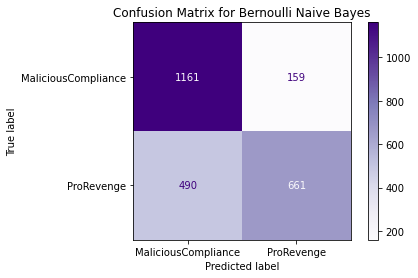

In [294]:
title = "Confusion Matrix for Bernoulli Naive Bayes"
disp = plot_confusion_matrix(bnb, X_test, y_test,
                            display_labels=['MaliciousCompliance','ProRevenge'],
                            cmap=plt.cm.Purples)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)


In [286]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_b).ravel()
print(f'Bernoulli Naive Bayes Specificity: {tn/(tn+fp)}')

Bernoulli Naive Bayes Specificity: 0.8795454545454545


Confusion Matrix for Logistic Regression
[[1165  155]
 [ 228  923]]


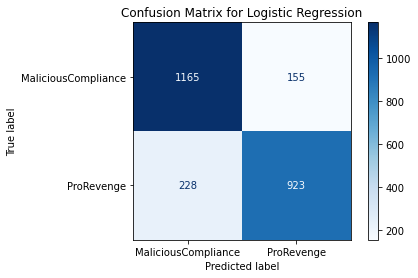

In [296]:
title = "Confusion Matrix for Logistic Regression"
disp = plot_confusion_matrix(logreg, X_test, y_test,
                            display_labels=['MaliciousCompliance','ProRevenge'],
                            cmap=plt.cm.Blues)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

In [285]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
print(f'Logistic Regression Specificity: {tn/(tn+fp)}')

Logistic Regression Specificity: 0.8825757575757576


Decision Tree. Code from Lesson 7.1 - Intro to Decision Trees. This classifier acts like an interrogator- passing the data through a series of decisions based on gini impurity to categorize.

In [238]:
# Define Gini function, called gini.
def gini(obs):
    
    # Create a list to store my squared class probabilities.
    gini_sum = []
    
    # Iterate through each class.
    for class_i in set(obs):
        
        # Calculate observed probability of class i.
        prob = (obs.count(class_i) / len(obs))
        #print(prob)
        
        # Square the probability and append it to gini_sum.
        gini_sum.append(prob ** 2)
        
    # Return Gini impurity.
    return 1 - sum(gini_sum)

In [248]:
dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)
y_train.value_counts().sort_index()

y_test.value_counts().sort_index()

MaliciousCompliance    1320
ProRevenge             1151
Name: subreddit, dtype: int64

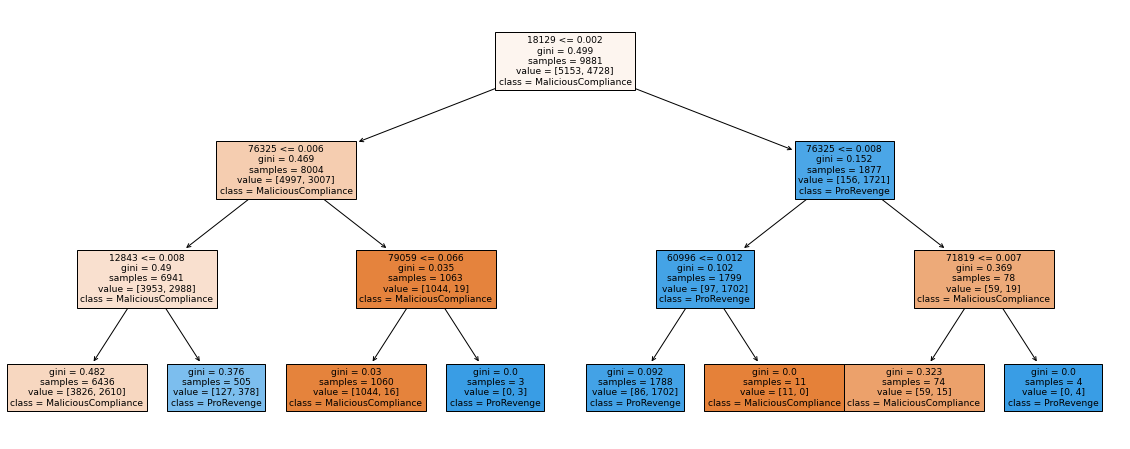

In [259]:
plt.figure(figsize=(20,8))
plot_tree(dtc, feature_names=vector_2.indices, 
          class_names=['MaliciousCompliance','ProRevenge'], filled=True);

In [261]:
# Evaluate model.
print(f'Score on training set: {dtc.score(X_train, y_train)}')
print(f'Score on testing set: {dtc.score(X_test, y_test)}')

Score on training set: 0.7111628377694565
Score on testing set: 0.7353298259813841
